In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import editdistance
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [27]:
import flexs
from flexs import baselines
import flexs.utils.sequence_utils as s_utils

In [3]:
palette = {
    'AdaLead': 'royalblue',
    'DynaPPO': 'gold',
    'CbAS': 'green',
    'DbAS': 'lightgreen',
    'Random baseline': 'gray',
    'Evo_BO' :'red',
    'CMAES': 'purple',
    'WF-a0.0': 'darkblue'
}

In [4]:
def get_maxes(pattern):
    '''Returns maximum true score in each csv matching `pattern`.'''
    maxes = []
    for fname in glob.glob(pattern):
        with open(fname) as f:
            # Skip metadata in header
            next(f)
            df = pd.read_csv(f)
        
#         if df['true_score'].max() < 0.9:
#             print(fname)
        
        maxes.append(df['true_score'].max())
    
    return maxes

## Figure 1A

## Figure 2A

../../paper_data_9_30/figure2a/cmaes/PAX3_G48R_R1_start2_cnn
../../paper_data_9_30/figure2a/cmaes/PAX3_G48R_R1_start1_cnn
../../paper_data_9_30/figure2a/cmaes/PAX3_G48R_R1_start4_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start1_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start0_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start2_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start3_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start11_cnn
../../paper_data_9_30/figure2a/cmaes/PAX3_G48R_R1_start12_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start6_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start4_cnn


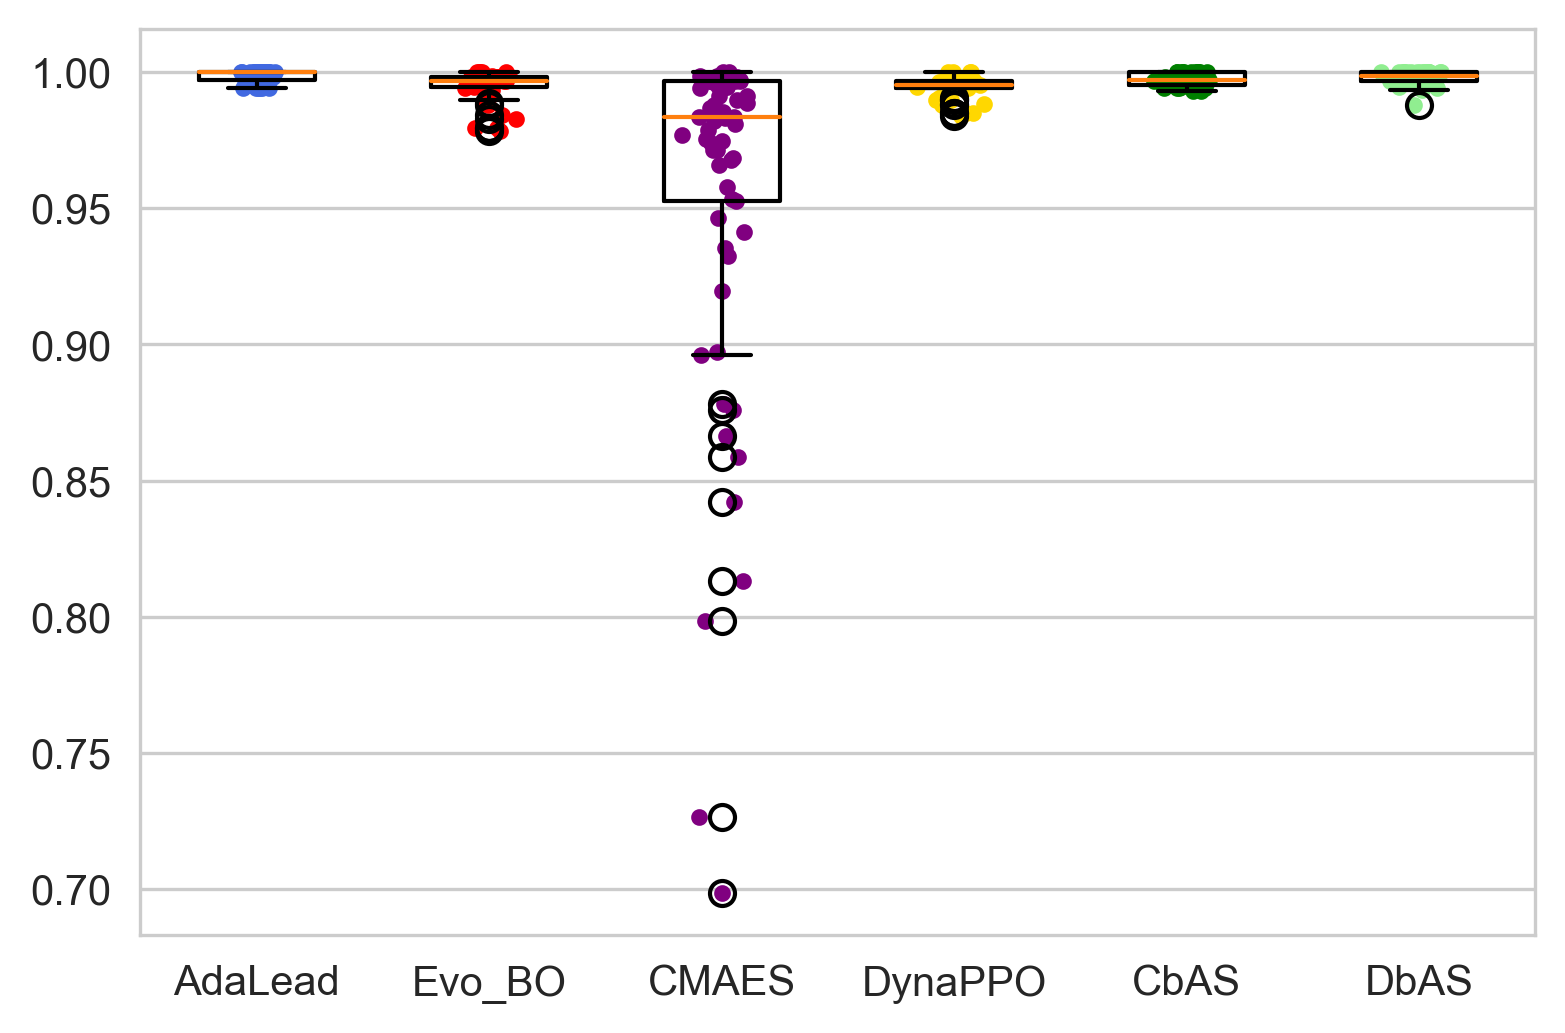

In [80]:
def jitter(x, size):
    return x + .05 * np.random.randn(size)

adalead_res = get_maxes('../../paper_data_9_30/figure2a/adalead/[!P]*R1*_cnn')
bo_res = get_maxes('../../paper_data_9_30/figure2a/bo/[!P]*R1*_cnn')
cmaes_res = get_maxes('../../paper_data_9_30/figure2a/cmaes/*R1*_cnn')
dynappo_res = get_maxes('../../paper_data_9_30/figure2a/dynappo/[!P]*R1*_cnn')
cbas_res = get_maxes('../../paper_data_9_30/figure2a/cbas/[!P]*R1*_cnn')
dbas_res = get_maxes('../../paper_data_9_30/figure2a/dbas/[!P]*R1*_cnn')

data = [adalead_res, bo_res, cmaes_res, dynappo_res, cbas_res, dbas_res]
names = ['AdaLead', 'Evo_BO', 'CMAES', 'DynaPPO', 'CbAS', 'DbAS']

plt.figure(dpi=300)
sns.set_style('whitegrid')
plt.grid(b=None, axis='x')
plt.boxplot(data, labels=names)
for i, (name, d) in enumerate(zip(names, data)):
    plt.scatter(jitter(i + 1, len(d)), d, c=palette[name], marker='.')
plt.show()

## Figure 2B Perfect Model (CNN at bottom)

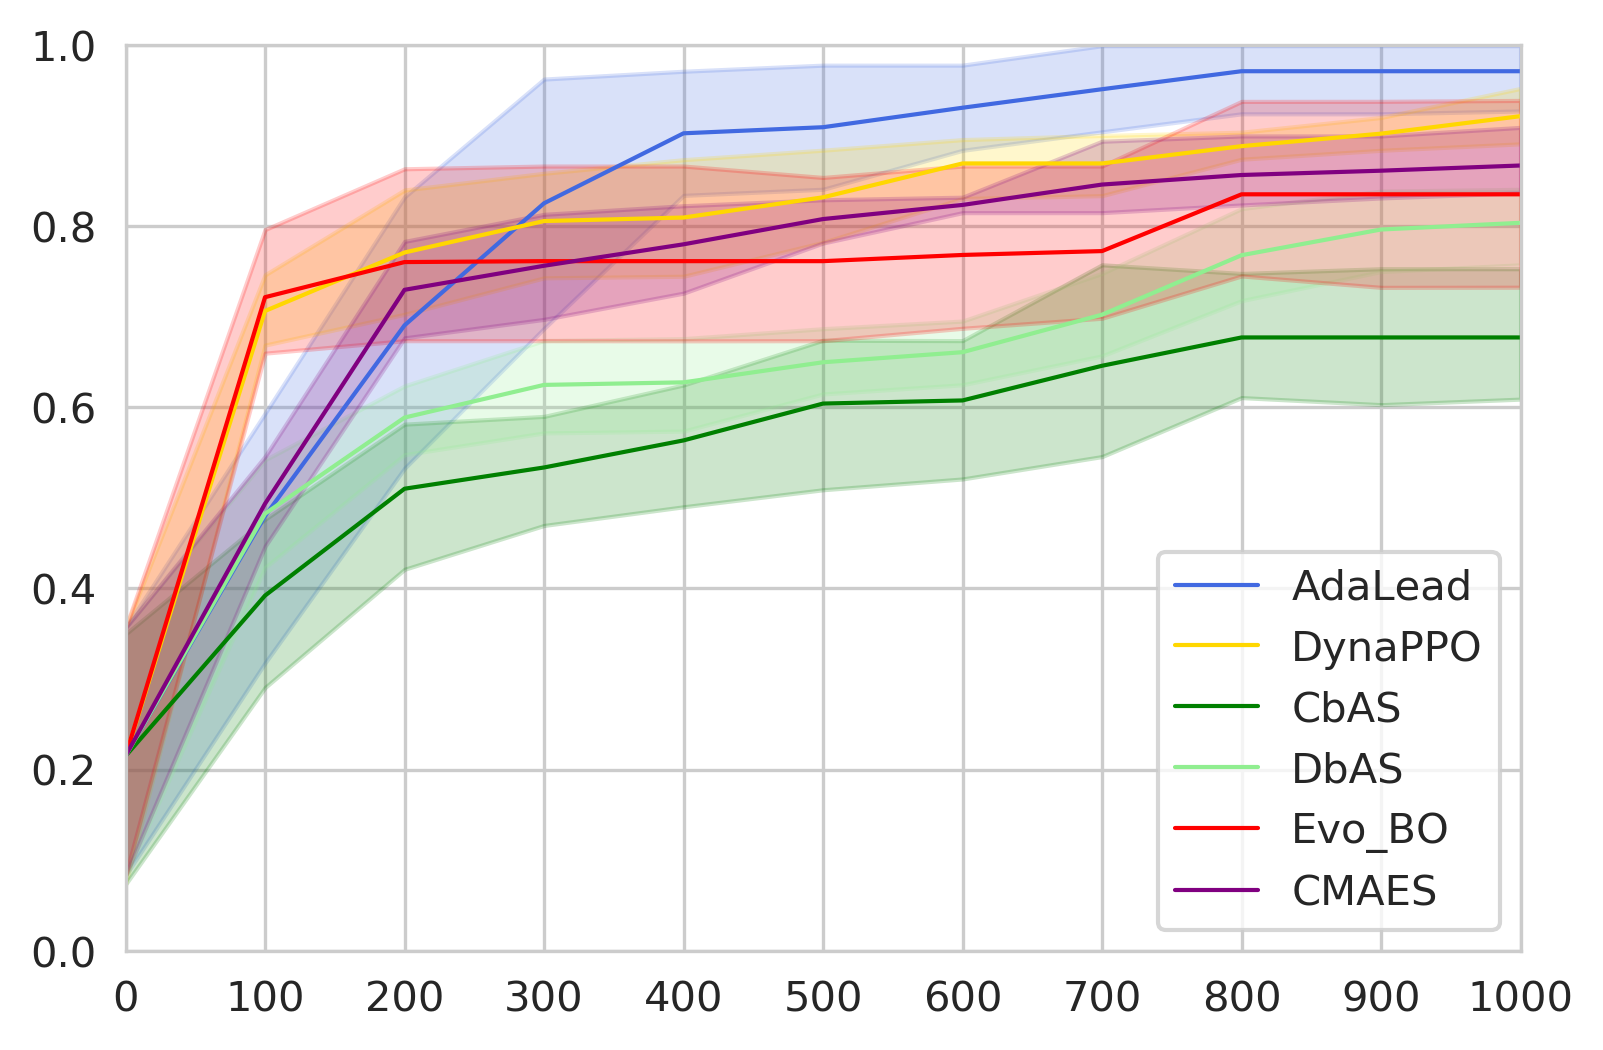

In [8]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]
    return np.maximum.accumulate(max_per_round)

def compute_scores(run_dir):
    measurements = []
    scores = []
    for fname in glob.glob(f'{run_dir}/L14_RNA1+2_start*_ss1.0'):
        # Skip metadata in header
        with open(fname) as f:
            next(f)
            df = pd.read_csv(f)

        max_per_round = cumulative_max_per_round(df)
        scores.extend(max_per_round)
        measurements.extend(range(len(max_per_round)))
    
    return list(measurements), list(0.96 * np.array(scores))

# OLD CSV HERE
df = pd.read_csv('../../L14RNA1+2runs_old.csv')
df = df[df['model_type'] != 'Null']

names_and_dirs = {
    'AdaLead': '../../paper_data_9_30/table1/adalead',
    'DynaPPO': '../../paper_data_9_30/table1/dynappo',
    'CbAS': '../../paper_data_9_30/table1/cbas',
    'DbAS': '../../paper_data_9_30/table1/dbas',
    'Evo_BO': '../../paper_data_9_30/table1/bo',
    'CMAES': '../../paper_data_9_30/table1/cmaes',
}

plt.figure(dpi=300)
sns.set_style('whitegrid')
for name, run_dir in names_and_dirs.items():
    new_x, new_y = compute_scores(run_dir)
    
    x = []
    y = []
    for start in ['startRNAL14_0', 'startRNAL14_1', 'startRNAL14_2', 'startRNAL14_3', 'startRNAL14_4']:
        for batch in range(1, 12):
            select_df = (df['explorer_type'] == name) & (df['model_type'] == 'AM(ss=1)') & (df['start_id'] == start) & (df['batch'] == batch)
            x.append(df['batch'][select_df].item() - 1)
            y.append(df['cum_max_fitness'][select_df].item())
            
    sns.lineplot(x + new_x, y + new_y, label=name, color=palette[name], linewidth=1)
plt.xticks(range(11), range(0, 10001, 100))
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [149]:
df['cum_max_fitness'][(df['explorer_type'] == 'AdaLead') &
                      (df['model_type'] == 'AM(ss=1)') &
                      (df['start_id'] == 'startRNAL14_0') &
                      (df['batch'] == 1)]

231    0.41898
Name: cum_max_fitness, dtype: float64

## Figure 2C

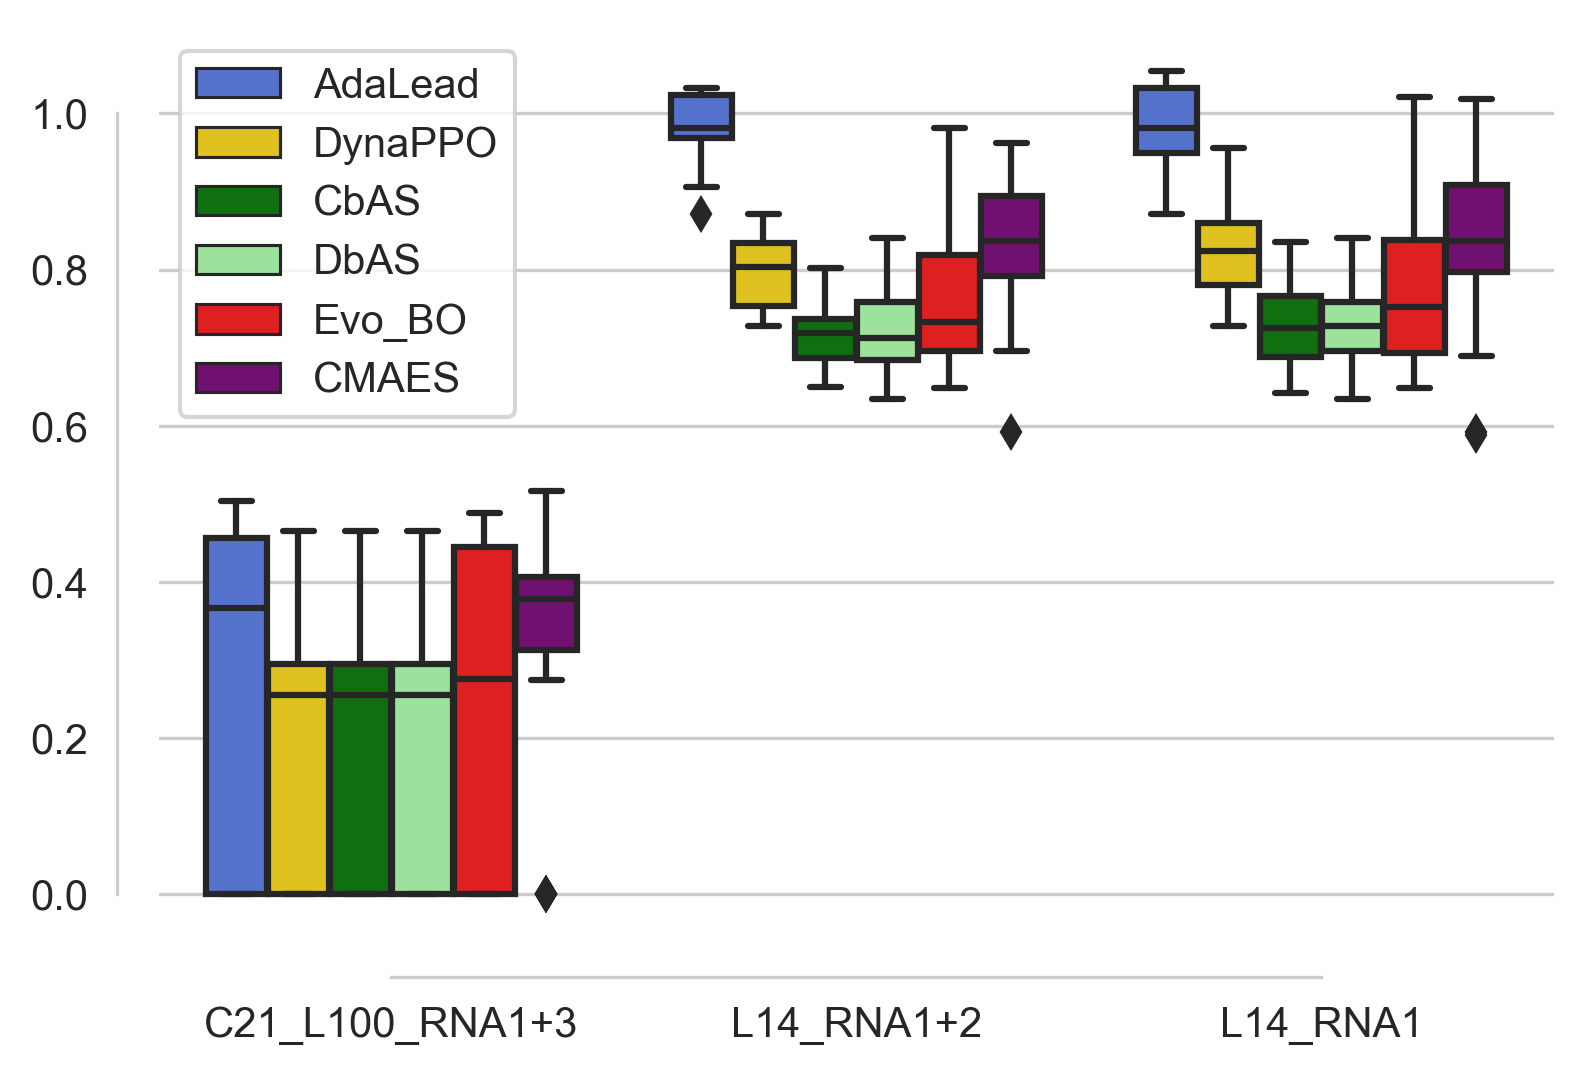

In [77]:
names_and_dirs = {
    'AdaLead': '../../paper_data_9_30/table1/adalead',
    'DynaPPO': '../../paper_data_9_30/table1/dynappo',
    'CbAS': '../../paper_data_9_30/table1/cbas',
    'DbAS': '../../paper_data_9_30/table1/dbas',
    'Evo_BO': '../../paper_data_9_30/table1/bo',
    'CMAES': '../../paper_data_9_30/table1/cmaes',
}

plt.figure(dpi=300)
sns.set_style('whitegrid')

data = {
    'landscape': [],
    'algo': [],
    'maxes': []
}
for i, landscape in enumerate(['C21_L100_RNA1+3', 'L14_RNA1+2', 'L14_RNA1']):
    for name, run_dir in names_and_dirs.items():
        for m in get_maxes(f'{run_dir}/{landscape}*ss*'):
            data['landscape'].append(landscape)
            data['algo'].append(name)
            data['maxes'].append(m)

sns.boxplot(x='landscape', y='maxes', hue='algo', palette=palette, data=data)
sns.despine(offset=10, trim=True)

plt.legend()
plt.show()

## Figure 2D

/usr/local/anaconda3/envs/.flexs-venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/anaconda3/envs/.flexs-venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/anaconda3/envs/.flexs-venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

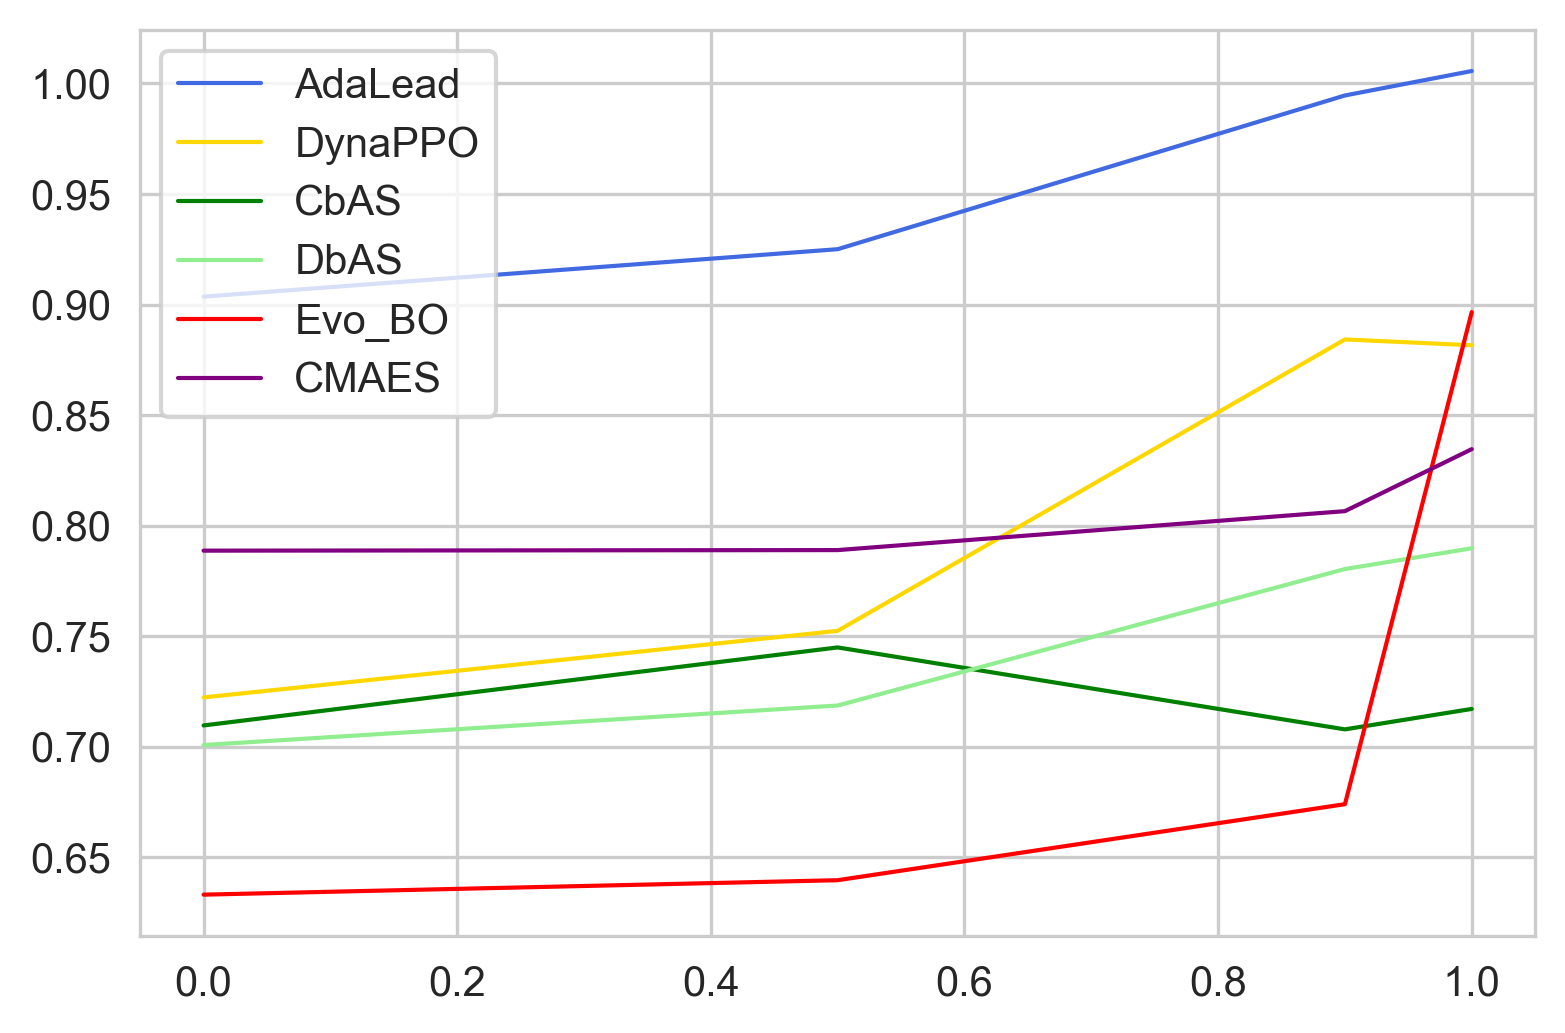

In [63]:
names_and_dirs = {
    'AdaLead': '../../paper_data_9_30/table1/adalead',
    'DynaPPO': '../../paper_data_9_30/table1/dynappo',
    'CbAS': '../../paper_data_9_30/table1/cbas',
    'DbAS': '../../paper_data_9_30/table1/dbas',
    'Evo_BO': '../../paper_data_9_30/table1/bo',
    'CMAES': '../../paper_data_9_30/table1/cmaes',
}

plt.figure(dpi=300)
sns.set_style('whitegrid')

# for name, run_dir in names_and_dirs.items():
#     ss_mean_maxes = [0.98 * np.mean(get_maxes(f'{run_dir}/L14_RNA1+2_start*_ss{ss}'))
#                      for ss in ['0.0', '0.5', '0.9', '1.0']]
    
#     plt.plot([0, 0.5, 0.9, 1], ss_mean_maxes, '-o', label=name, color=palette[name], linewidth=1)

# plt.ylim(0.5)
# plt.legend()
# plt.show()

def compute_scores(run_dir, start, ss):
    measurements = []
    scores = []
    for fname in glob.glob(f'{run_dir}/L14_RNA1+2_start{start}_ss{ss}'):
        # Skip metadata in header
        with open(fname) as f:
            next(f)
            df = pd.read_csv(f)

        max_per_round = cumulative_max_per_round(df)
        scores.extend(max_per_round)
        measurements.extend(range(len(max_per_round)))
    
    return list(measurements), list(0.96 * np.array(scores))

for name, run_dir in names_and_dirs.items():
    indices = []
    maxes = []
    for ss, _ss in zip(['0', '0.5', '0.9', '1'], ['0.0', '0.5', '0.9', '1.0']):
        tmp = []
        for start, _start in zip(['startRNAL14_0', 'startRNAL14_1', 'startRNAL14_2', 'startRNAL14_3', 'startRNAL14_4'], ['0', '1', '2', '3', '4']):
            select_df = (df['explorer_type'] == name) & (df['model_type'] == f'AM(ss={ss})') & (df['start_id'] == start)
            tmp.append(df['max_fitness'][select_df].max())
            _, new_max = compute_scores(run_dir, _start, _ss)
            tmp.append(np.max(new_max))
#         maxes.append(0.98 * np.mean(tmp))
#             maxes.append(df['max_fitness'][select_df].max())
#             maxes.append(np.max(new_max))
        maxes.append(np.mean(tmp))
        indices.append(float(ss))
#             indices.append(float(ss))
            
    sns.lineplot(indices, maxes, label=name, color=palette[name], linewidth=1, err_style='bars', ci=68)
# plt.xticks(range(11), range(0, 10001, 100))
# plt.xlim(0, 10)
# plt.ylim(0, 1)
plt.legend()
plt.show()

## Rosetta Plot

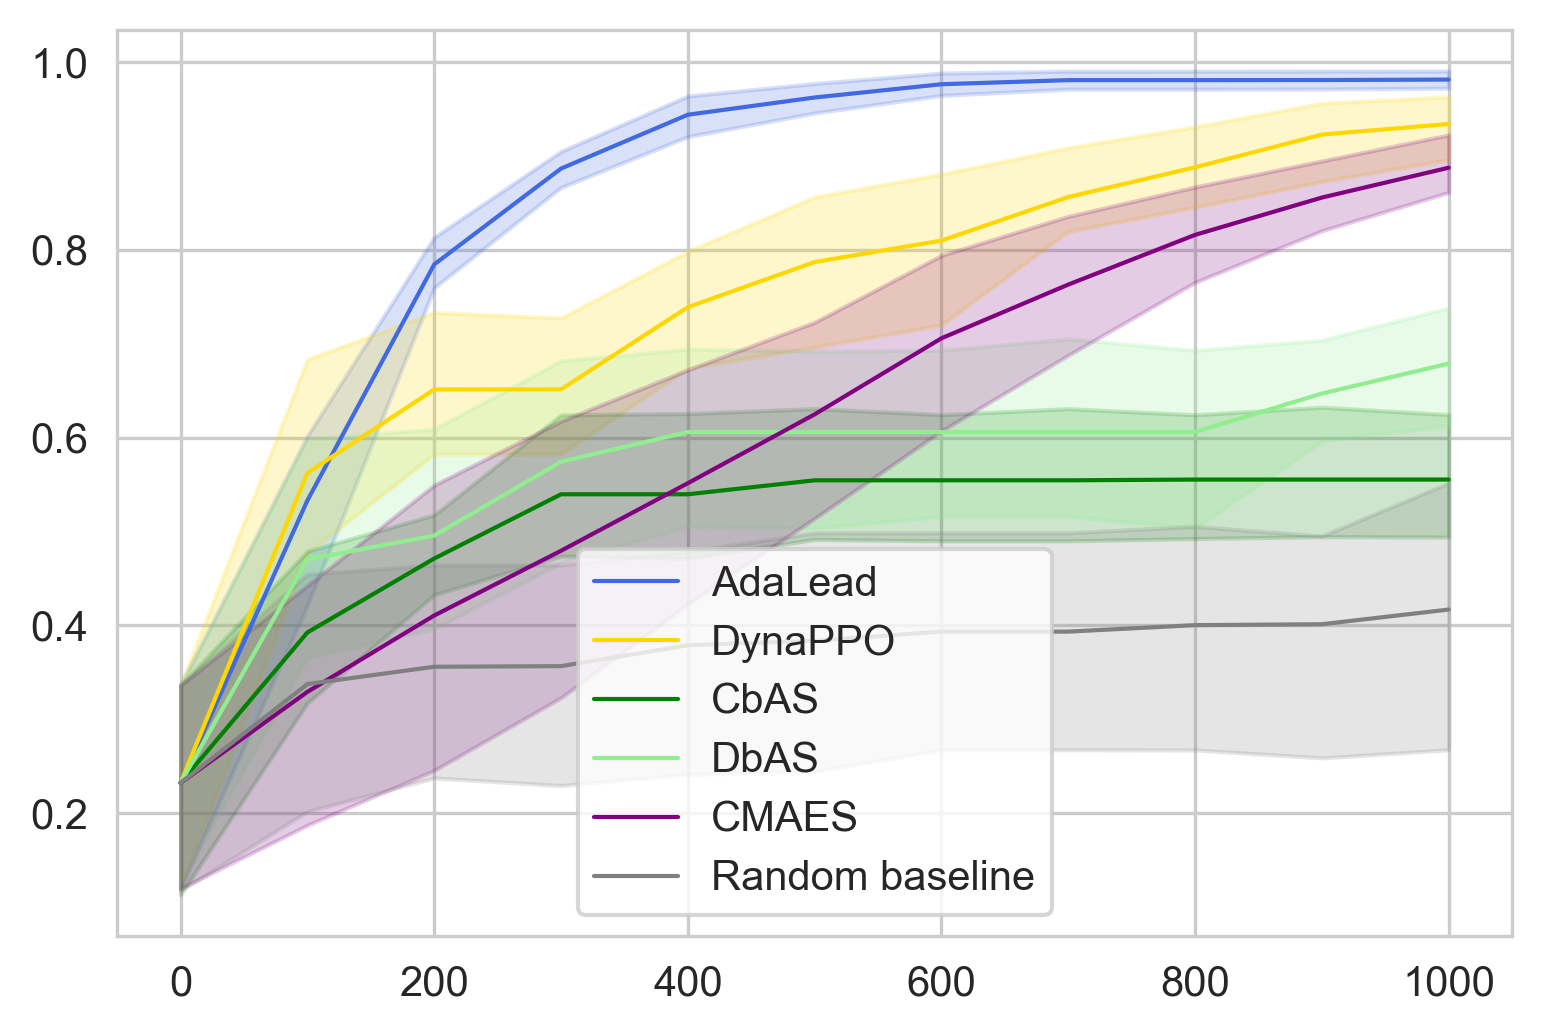

In [47]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]
    return np.maximum.accumulate(max_per_round)

def compute_scores(run_dir):
    measurements = []
    scores = []
    for fname in glob.glob(f'{run_dir}/*'):
        # Skip metadata in header
        with open(fname) as f:
            next(f)
            df = pd.read_csv(f)

        max_per_round = cumulative_max_per_round(df)
        scores.extend(max_per_round)
        measurements.extend(np.arange(len(max_per_round)) * 100)
    
    return measurements, scores

names_and_dirs = {
    'AdaLead': '../cloud/runs/3msi/adalead',
    'DynaPPO': '../cloud/runs/3msi/dynappo',
    'CbAS': '../cloud/runs/3msi/cbas',
    'DbAS': '../cloud/runs/3msi/dbas',
    'CMAES': '../cloud/runs/3msi/cmaes',
    'Evo_BO': '../cloud/runs/3msi/bo',
    'Random baseline': '../cloud/runs/3msi/random',
}

plt.figure(dpi=300)
sns.set_style('whitegrid')
for name, run_dir in names_and_dirs.items():
    sns.lineplot(*compute_scores(run_dir), label=name, color=palette[name], linewidth=1)
plt.legend()
plt.show()

## Figure 2B CNN

/usr/local/anaconda3/envs/.flexs-venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/anaconda3/envs/.flexs-venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


CbAS startRNAL14_0 1
CbAS startRNAL14_0 2
CbAS startRNAL14_0 3
CbAS startRNAL14_0 4
CbAS startRNAL14_0 5
CbAS startRNAL14_0 6
CbAS startRNAL14_0 7
CbAS startRNAL14_0 8
CbAS startRNAL14_0 9
CbAS startRNAL14_0 10
CbAS startRNAL14_0 11
CbAS startRNAL14_1 1
CbAS startRNAL14_1 2
CbAS startRNAL14_1 3
CbAS startRNAL14_1 4
CbAS startRNAL14_1 5
CbAS startRNAL14_1 6
CbAS startRNAL14_1 7
CbAS startRNAL14_1 8
CbAS startRNAL14_1 9
CbAS startRNAL14_1 10
CbAS startRNAL14_1 11
CbAS startRNAL14_3 1
CbAS startRNAL14_3 2
CbAS startRNAL14_3 3
CbAS startRNAL14_3 4
CbAS startRNAL14_3 5
CbAS startRNAL14_3 6
CbAS startRNAL14_3 7
CbAS startRNAL14_3 8
CbAS startRNAL14_3 9
CbAS startRNAL14_3 10
CbAS startRNAL14_3 11


/usr/local/anaconda3/envs/.flexs-venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


DbAS startRNAL14_0 1
DbAS startRNAL14_0 2
DbAS startRNAL14_0 3
DbAS startRNAL14_0 4
DbAS startRNAL14_0 5
DbAS startRNAL14_0 6
DbAS startRNAL14_0 7
DbAS startRNAL14_0 8
DbAS startRNAL14_0 9
DbAS startRNAL14_0 10
DbAS startRNAL14_0 11
DbAS startRNAL14_1 1
DbAS startRNAL14_1 2
DbAS startRNAL14_1 3
DbAS startRNAL14_1 4
DbAS startRNAL14_1 5
DbAS startRNAL14_1 6
DbAS startRNAL14_1 7
DbAS startRNAL14_1 8
DbAS startRNAL14_1 9
DbAS startRNAL14_1 10
DbAS startRNAL14_1 11
DbAS startRNAL14_2 1
DbAS startRNAL14_2 2
DbAS startRNAL14_2 3
DbAS startRNAL14_2 4
DbAS startRNAL14_2 5
DbAS startRNAL14_2 6
DbAS startRNAL14_2 7
DbAS startRNAL14_2 8
DbAS startRNAL14_2 9
DbAS startRNAL14_2 10
DbAS startRNAL14_2 11
DbAS startRNAL14_4 1
DbAS startRNAL14_4 2
DbAS startRNAL14_4 3
DbAS startRNAL14_4 4
DbAS startRNAL14_4 5
DbAS startRNAL14_4 6
DbAS startRNAL14_4 7
DbAS startRNAL14_4 8
DbAS startRNAL14_4 9
DbAS startRNAL14_4 10
DbAS startRNAL14_4 11


/usr/local/anaconda3/envs/.flexs-venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/anaconda3/envs/.flexs-venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/anaconda3/envs/.flexs-venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

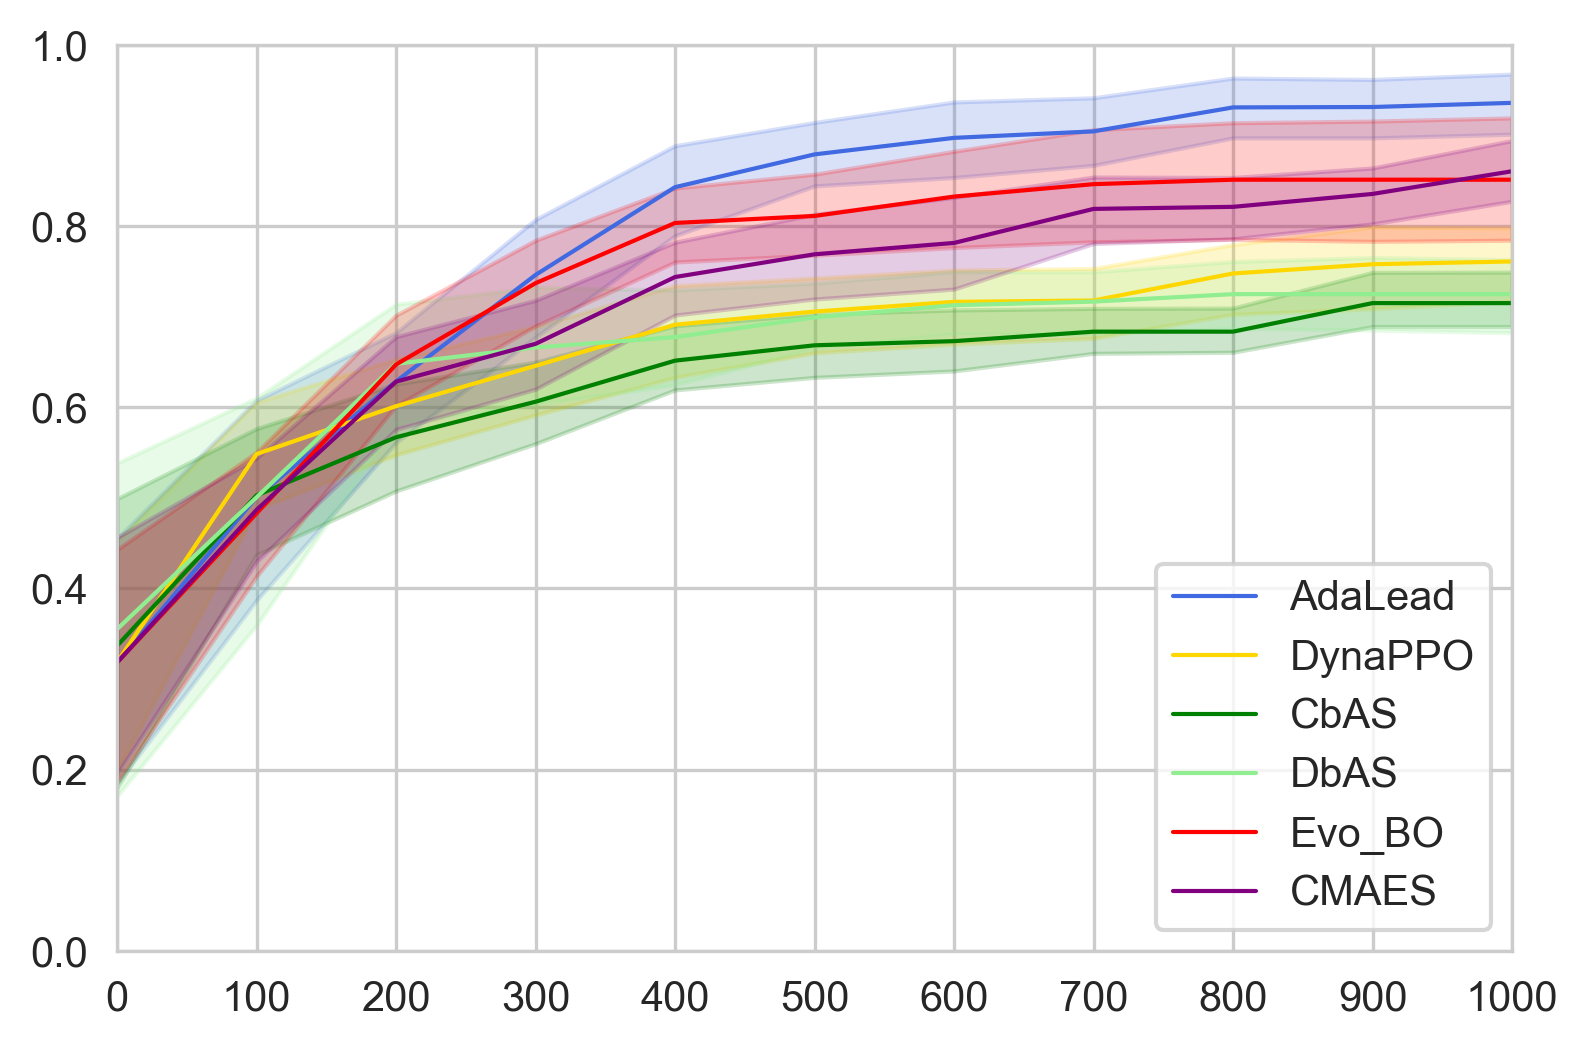

In [82]:
# Fig 2B CNN

def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]
    return np.maximum.accumulate(max_per_round)

def compute_scores(run_dir):
    measurements = []
    scores = []
    for fname in glob.glob(f'{run_dir}/L14_RNA1+2_start*_cnn'):
        # Skip metadata in header
        with open(fname) as f:
            next(f)
            df = pd.read_csv(f)

        max_per_round = cumulative_max_per_round(df)
        scores.extend(max_per_round)
        measurements.extend(range(len(max_per_round)))
    
    return list(measurements), list(0.96 * np.array(scores))

names_and_dirs = {
    'AdaLead': '../../paper_data_9_30/table1/adalead',
    'DynaPPO': '../../paper_data_9_30/table1/dynappo',
    'CbAS': '../../paper_data_9_30/table1/cbas',
    'DbAS': '../../paper_data_9_30/table1/dbas',
    'Evo_BO': '../../paper_data_9_30/table1/bo',
    'CMAES': '../../paper_data_9_30/table1/cmaes',
}

plt.figure(dpi=300)
plt.xticks(range(11), range(0, 1001, 100))
plt.xlim(0, 10)
plt.ylim(0, 1)
sns.set_style('whitegrid')
for name, run_dir in names_and_dirs.items():
    new_x, new_y = compute_scores(run_dir)
    
    x = []
    y = []
    for start in ['startRNAL14_0', 'startRNAL14_1', 'startRNAL14_2', 'startRNAL14_3', 'startRNAL14_4']:
        for batch in range(1, 12):
            select_df = (df['explorer_type'] == name) & (df['model_type'] == 'Ensemble') & (df['start_id'] == start) & (df['batch'] == batch)
            if len(df['batch'][select_df]) == 0:
                print(name, start, batch)
                continue
            x.append(df['batch'][select_df].item() - 1)
            y.append(df['cum_max_fitness'][select_df].item())
            
    sns.lineplot(x + new_x, y + new_y, label=name, color=palette[name], linewidth=1)
plt.legend()
plt.show()

In [78]:
df[df['explorer_type'] == 'CbAS'][df['model_type'] == 'Ensemble']

/usr/local/anaconda3/envs/.flexs-venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,batch,cum_max_fitness,explorer_type,landscape_id,max_fitness,model_type,start_id
1210,0,1,0.072638,CbAS,B2L14RNA1+2,0.077723,Ensemble,startRNAL14_2
1211,0,2,0.490770,CbAS,B2L14RNA1+2,0.525124,Ensemble,startRNAL14_2
1212,0,3,0.490770,CbAS,B2L14RNA1+2,0.464448,Ensemble,startRNAL14_2
1213,0,4,0.490770,CbAS,B2L14RNA1+2,0.418004,Ensemble,startRNAL14_2
1214,0,5,0.747567,CbAS,B2L14RNA1+2,0.799896,Ensemble,startRNAL14_2
1215,0,6,0.747567,CbAS,B2L14RNA1+2,0.546191,Ensemble,startRNAL14_2
1216,0,7,0.747567,CbAS,B2L14RNA1+2,0.581206,Ensemble,startRNAL14_2
1217,0,8,0.747567,CbAS,B2L14RNA1+2,0.752436,Ensemble,startRNAL14_2
1218,0,9,0.747567,CbAS,B2L14RNA1+2,0.559820,Ensemble,startRNAL14_2
1219,0,10,0.747567,CbAS,B2L14RNA1+2,0.623007,Ensemble,startRNAL14_2


In [83]:
df['explorer_type'].unique()

array(['AdaLead', 'DynaPPO', 'CbAS', 'DbAS', 'Evo_BO',
       'Evolution baseline', 'CMAES'], dtype=object)